<a href="https://colab.research.google.com/github/KarelZe/adv-ml/blob/main/AML_Bonus_MarkusBilz_2327197_VerenaHollinger_2055134.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install imbalanced-learn

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from google.colab import drive
from imblearn.over_sampling import SMOTE
from sklearn import tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV, LogisticRegression, lasso_path
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    classification_report,
    matthews_corrcoef,
    plot_confusion_matrix,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from yellowbrick.classifier.rocauc import roc_auc

# apply some custom styling to charts
sns.set_theme(style="whitegrid", palette="rocket", font_scale=1.1, color_codes=True)
cmap = sns.cm.rocket

import matplotlib.pyplot as plt
%matplotlib inline

# increase the number of rows displayed to fully display all (transposed) features.
pd.options.display.max_rows = 1000


# Task 1: Explain dataset and business problems in two paragraphs. (10 points)

Peer-2-Peer Lending is a decentralized approach in which investors (most oftenly private investors) lend to debtors (typically private individuals). Peer-2-peer lending platforms such as Lending Club serve as an intermediary between investors and borrowers. Due to the decentralized structure, no banks are involved. The risk for a loan is that the borrower defaults partly or entirely. Expected interest and redemption payments may then not be made. The borrowers suffer a loss. Typically, investors invest in several loans to diversify their default risk. Ergo, one loan is financed by several investors. Of central interest is whether a default of a loan can be predicted and with which features. The platform could use this information to reject loans that are highly likely to default during the application process, thus avoiding defaults.

The dataset contains loan data on loans, that where distributed through the peer-2-peer lending platform Lending club. The data includes information on payment history, loan terms, borrower information and most importantly the loan status. In overview, data can be classified into hard and soft features. Some features are categorical e. g. term, while others are numerical e. g. debt-to-income-ratio or unstructured e. g. purpose.


**TODO: Hard vs. Soft features.**
**sollen wir sowas wie Anzahl features und Anzahl columns ergänzen?**



## Loading the data

Loan data is available from kaggle. The loan data is stored unaltered in our Google Drive.

Additional income data was downloaded from the [US Census Bureau](https://data.census.gov/cedsci/table?q=S1901%3A%20INCOME%20IN%20THE%20PAST%2012%20MONTHS%20%28IN%202018%20INFLATION-ADJUSTED%20DOLLARS%29&g=0400000US01,02,04,05,06,08,09,10,12,13,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,44,45,46,47,48,49,50,51,53,54,55,56,72&tid=ACSST1Y2018.S1901&hidePreview=false). We use this information later in our analysis to compare the income of borrowers with the avg. income of the state they are located int. To be able to map US state names to their corresponding ISO-Codes we use es use the table found at [ISO.org](https://www.iso.org/obp/ui/#iso:code:3166:US) as a lookup table.

In [ ]:
drive.mount("/content/drive")

data = pd.read_csv('/content/drive/My Drive/AdvancedML/accepted_2007_to_2018Q4.csv')
income_by_states = pd.read_csv(
    '/content/drive/My Drive/AdvancedML/ACSST1Y2018_S1901_data_with_overlays_2021-06-12T020307.csv')

# Task 2: Do an explanatory analysis for this dataset. (10 points)

In [ ]:
print(data.shape)

The dataset consists of ~ 2.26 million loans and 151 features.

In [ ]:
data.head().T

In [ ]:
data.describe(include='all').T

Not all features are known at the time, when the loan is handed out. E. g. 'hardship_dpd' is not known. Therefore, a preselection is done to those features that can be known during the application process by using a [dictionary](https://drive.google.com/file/d/1UzyKMtrzL3aEEQpeYIz_qjBWyW-lAMr0/view). We restrict our further analysis to thhose features.

Moreover, the columns `url` or `desc`, as the info is no longer available on the lending club website.

Finally, we also drop the column `id`, as it is unique to the loan, but can not be used for a default prediction.

In [ ]:
a_priori_known = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade',
                  'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
                  'issue_d', 'loan_status', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
                  'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq',
                  'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
                  'initial_list_status', 'next_pymnt_d', 'last_credit_pull_d', 'last_fico_range_high',
                  'last_fico_range_low', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code',
                  'application_type', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'acc_now_delinq',
                  'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m',
                  'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc',
                  'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths',
                  'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt',
                  'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
                  'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl',
                  'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m',
                  'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75',
                  'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
                  'total_il_high_credit_limit', 'revol_bal_joint']

# filter columns of data frame, that can be known in advance
data = data[a_priori_known]

Next, we look at missing data.

In [ ]:
data.isna().sum()

or visually for the first 50 rows:

In [ ]:
def visualize_nan():
    plt.subplots(figsize=(20, 10))
    sns.heatmap(data.head(50).isnull(), cbar=False)
    plt.xlabel("feature")
    plt.ylabel("row")
    plt.title("Viz. of missing values (colored in bright beige)")
    plt.show();

As it can be seen above, there is a high of missing data. While `dt_joint` and `acc_now_delinq` are missing more often than other features such as `title`, To further quantify this discovery, we use use a pareto plot in the next step. The missing values appear in a *completely random (MCAR)* fashion.

In [ ]:
missing_val = data.isna().sum()
missing_val.sort_values(ascending=False, inplace=True)

missing_val = missing_val[missing_val > 1]
missing_val = missing_val.to_frame()

missing_val['pareto'] = 100 * missing_val[0].cumsum() / missing_val[0].sum()
missing_val.rename(columns={0: 'nan'}, inplace=True)

print(missing_val.tail())

In [ ]:
fig, axes = plt.subplots(figsize=(20, 10))
ax1 = missing_val.plot(use_index=True, y='nan', kind='bar', ax=axes)
ax2 = missing_val.plot(use_index=True, y='pareto', marker='D', color="C1", kind='line', ax=axes, secondary_y=True)
ax2.set_ylim([0, 110])
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
plt.xticks(rotation=45)
plt.title("Pareto plot of missing values by column")
plt.show()

To fix the problem of columns with a high degree of missing values, we exclude columns with more than 20 % of missing values. We are aware, that by removing features a bias is introduced. However, it's common practice to remove columns above this threshold, as shown in (...).

In [ ]:
threshold = 0.80

percentage_missing_val = data.isna().sum() / len(data)

percentage_missing_val = percentage_missing_val[percentage_missing_val >= threshold]
threshold_abs = int(threshold * len(data))
data = data.dropna(axis=1, thresh=threshold_abs)

print(percentage_missing_val)

In [ ]:
visualize_nan()

Looking at the Data Frame again...


Some rows are present, where the volume and many other features are null. We exclude these loans without volume from analysis.



In [ ]:
data = data[data.loan_amnt.notna()]

This leads to the following result...

In [ ]:
visualize_nan()

In [ ]:
# convert to categorical
categorical = ['addr_state', 'term', 'application_type', 'initial_list_status', 'loan_status', 'grade', 'sub_grade',
               'home_ownership', 'verification_status', 'purpose', 'emp_length', 'zip_code']
data[categorical] = data[categorical].apply(lambda x: x.astype('category'))

# convert to string
strs = ['emp_title', 'title']
data[strs] = data[strs].apply(lambda x: x.astype('string'))

# convert to datetime
dts = ['earliest_cr_line', 'issue_d', 'last_credit_pull_d']
data[dts] = data[dts].apply(lambda x: pd.to_datetime(x, format="%b-%Y", errors='coerce'))


print(data.dtypes)

##Number of unique classes per feature

In [ ]:
data_classes = []
for row in data.columns.tolist():
    data_classes.append({'column': row, 'count': len(data[row].unique())})
amount = pd.DataFrame(data_classes).sort_values('count')
print(amount)

The features `purpose` and `title` contain similar content. Since `purpose` only contains 14 classes and `title` contains more than 60,000 classes we keep `purpose` and drop `title`.

More over we drop `emp_title`, as it contains either free-text or a high number of unique values, which is true for the later. We expect little loss in information by deleting these variables.

As `policy_code` is constant, it can be also dropped.

In [ ]:
data = data.drop(columns=['emp_title', 'title', 'policy_code'])

Next, we analyze categorical features by looking at their $k$ most frequent values.

In [ ]:
k = 10
data['term'].value_counts().head(k)

In [ ]:
data['addr_state'].value_counts().head(k)

In [ ]:
data['application_type'].value_counts().head(k)

In [ ]:
data['initial_list_status'].value_counts().head(k)

In [ ]:
data['loan_status'].value_counts().head(k)

In [ ]:
data['grade'].value_counts().head(k)

In [ ]:
data['sub_grade'].value_counts().head(k)

In [ ]:
data['home_ownership'].value_counts().head(k)

In [ ]:
data['verification_status'].value_counts().head(k)

In [ ]:
data['purpose'].value_counts().head(k)

In [ ]:
data['emp_length'].value_counts().head(k)

##Analyze loan status
In a first step the different loan status categories and their quantities are identified to categorize them in "default" and "non-default"

In [ ]:
data['loan_status'].value_counts()

In [ ]:
loan_status_absolute = data['loan_status'].value_counts()
loan_status_absolute = loan_status_absolute.to_frame()

fig, ax = plt.subplots(figsize=(20, 10))
plt.ticklabel_format(style='plain')
sns.barplot(x='loan_status', y=loan_status_absolute.index, data=loan_status_absolute, ax=ax)

Next, we group `loan_status` to be either default or non-default to allow for binary classsification. We save the result as `TARGET`.

We apply the same grouping as *Vinod Kumar, Natajan et. al* in *Credit Risk Analysis in Peer-to-Peer Lending System*.

In [ ]:
default_categories = ['Default', 'Charged Off', 'Late (31-120 days)', 'Late (16-30 days)', 'Does not meet the credit policy. Status:Charged Off']
data['TARGET'] = data['loan_status'].isin(default_categories)

data['TARGET'].value_counts()

In [ ]:
_, ax = plt.subplots(figsize=(20, 10))
plt.ticklabel_format(style='plain')
g = sns.countplot(x='TARGET', hue='loan_status', data=data)
g.legend(loc='upper right', bbox_to_anchor=(1.1, 1), ncol=1)
plt.show();

## default status by debt-to-income-ratio
- For calculation of debt-to-income-ratio see [here.](https://www.lendingclub.com/loans/resource-center/calculating-debt-to-income)

**expectation**
- One would expect more defaults with a higher debt-to-income ratio, but no clear trend can be derived from data.

In [ ]:
g = sns.displot(data, x='dti', hue='TARGET', multiple='fill', legend=False, height=10, aspect=20 / 10, alpha=1,
                bins=1000)
plt.title("default status by debt to income ratio in relative numbers")
plt.xlim(0, 100)
plt.legend(title='Defaulted', loc='upper right', labels=['Default', 'Non-Default'], bbox_to_anchor=(1.1, 1))
plt.show(g);

## default status by term structure and amount

In [ ]:
plt.figure(figsize=(20, 10))
sns.violinplot(x="TARGET", y="loan_amnt", data=data, hue="term", split=True)
plt.title("default by term structure and amount")
plt.xlabel("defaulted")
plt.ylabel("Loan amount")
plt.legend(bbox_to_anchor=(1.2, 1));

## default status by grade

**expectation**
- Loans with a lower rating inherit a higher risk of default.

In [ ]:
g = sns.displot(data, x='grade', hue='TARGET', multiple='stack', legend=False, height=10, aspect=20 / 10, alpha=1);
plt.title("default status by grade")
plt.legend(title='Defaulted', loc='upper right', labels=['Default', 'Fully paid'], bbox_to_anchor=(1.1, 1))
plt.show(g);

In [ ]:
# TODO: As observed by researchers xy...

g = sns.displot(data, x='grade', hue='TARGET', multiple='fill', legend=False, height=10, aspect=1, alpha=1)
plt.title("default status by grade in relative numbers")
plt.legend(title='Defaulted', loc='upper right', labels=['Default', 'Non-Default'], bbox_to_anchor=(1.2, 1))
plt.show(g);

## default status by grade and interest rate

In [ ]:
plt.figure(figsize=(20, 10))
sns.violinplot(x="TARGET", y="int_rate", data=data, hue="grade")
plt.legend(bbox_to_anchor=(1.1, 1))
plt.title("interest rate by grade and default status")
plt.xlabel("defaulted")
plt.ylabel("Interest Rate");

# Default status by application type

**expectation**
- Joint applications inherit lower risk of default.

In [ ]:
fig = plt.figure(figsize=(18, 8))
sns.violinplot(x="TARGET", y="loan_amnt", data=data, hue="application_type", split=True)
plt.title("default by amount and application type")
plt.xlabel("defaulted")
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), ncol=1, labels=['Individual', 'Joint Application']);
plt.ylabel("Loan Amount");

## Default status by working experience

**expectation**
- The longer the working experience, the smaller the probability of default.

In [ ]:
fig = plt.figure(figsize=(20, 10))

sns.countplot(x='emp_length', hue='TARGET', data=data, order=data['emp_length'].value_counts().index)
plt.xlabel('Employee Working Experience')
plt.legend(title='Defaulted', loc='upper right', labels=['Default', 'Non-Default'], bbox_to_anchor=(1.15, 1))
plt.show()

## Default status by state

**expectation**
- None.

In [ ]:
plt.figure(figsize=(10, 20))
plt.ticklabel_format(style='plain')
g = sns.countplot(y='addr_state', hue='TARGET', data=data, ax=ax)
plt.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=1, labels=['Default', 'Fully paid'])
plt.ylabel("state")
plt.xlabel("count")
plt.show(g);

In [ ]:
# TODO: Discussion IA vs. ID (few observations)

g = sns.displot(data, y='addr_state', hue='TARGET', multiple='fill', legend=False, height=20, aspect=10 / 20, alpha=1)
plt.title("default status by state in relative numbers")
plt.legend(title='Defaulted', loc='upper right', labels=['Default', 'Non-Default'], bbox_to_anchor=(1.1, 1))
plt.ylabel("state")
plt.xlabel("density")
plt.show(g);

## default status by purpose

In [ ]:
_, ax = plt.subplots(figsize=(10, 10))
plt.ticklabel_format(style='plain')
g = sns.countplot(y='loan_status', hue='TARGET', data=data, ax=ax)
g.legend(loc='upper right', bbox_to_anchor=(1.2, 1), ncol=1, labels=['Default', 'Fully paid'])
plt.ylabel("loan status")
plt.show();

## Interest rate by grade

In [ ]:
plt.figure(figsize=(12, 10))
g = sns.boxplot(data=data, x='grade', y='int_rate')
plt.title("interest rate by grade")
plt.show(g);

## default status by interest rate

In [ ]:
plt.figure(figsize=(20, 10))
bins = np.linspace(5, 33, 33)
g = sns.histplot(data, x='int_rate', hue='TARGET', multiple='dodge', legend=False, alpha=1, bins=bins);
plt.title("default status by interest rate")
plt.legend(title='Defaulted', loc='upper right', labels=['Default', 'Fully paid'], bbox_to_anchor=(1.1, 1))
plt.xlabel("interest rate")
plt.ylabel("count")
plt.show(g);

In [ ]:
# TODO: Mind bin size. There are interest rates with only few loans. This might lead to distortions.

g = sns.displot(data, x='int_rate', hue='TARGET', multiple='fill', legend=False, height=10, bins=50, aspect=20 / 10,
                alpha=1)
plt.title("default status by interest rate in relative numbers")
plt.legend(title='Defaulted', loc='upper right', labels=['Default', 'Non-Default'], bbox_to_anchor=(1.1, 1))
plt.xlabel("interest rate in %")
plt.ylabel("density")
plt.show();

## Analyze income


In [ ]:
income_by_states = income_by_states[['NAME', 'S1901_C01_013E']]
income_by_states.rename(columns={'NAME': 'state', 'S1901_C01_013E': 'income'}, inplace=True)

income_by_states.head(60)

In [ ]:
state_map = pd.read_csv("/content/drive/My Drive/AdvancedML/states_mapping.csv", sep=';')
state_map.head(50)

In [ ]:
# remove comments from df
income_by_states.drop(income_by_states.index[[0]], inplace=True)

# add iso codes and make subselection
income_by_states = income_by_states.merge(state_map, how='left', left_on='state', right_on='subdivision_name')
income_by_states = income_by_states[['iso_code', 'income']]

income_by_states.head(60)

In [ ]:
lut_income = dict(income_by_states.values)
data["addr_state_avg_income"] = data["addr_state"].replace(lut_income)
data["addr_state_avg_income"] = data["addr_state_avg_income"].apply(lambda x: pd.to_numeric(x, errors="coerce"))
data["state_income_ratio"] = data["annual_inc"] / data["addr_state_avg_income"]
data.head().T

In [ ]:
plt.figure(figsize=(20, 10))
bins = np.linspace(0, 300000, 60)
sns.histplot(data=data, x='annual_inc', bins=bins, kde=False, alpha=1)
plt.title("Distribution of annual income")
plt.xlim(0, 300000)
plt.xlabel("annual income")
plt.ylabel("count")
plt.show()

## Annual Income and Loan Amount of defaulted loans

In [ ]:
plt.figure(figsize=(20, 20))
sel_annual_inc_defaulted = data[(data.annual_inc <= 300000) & (data.TARGET == 1)]
sns.jointplot(data=sel_annual_inc_defaulted, x="annual_inc", y="loan_amnt", kind="hex", height=12)
plt.xlabel("annual income")
plt.ylabel("loan amount")
plt.title("Distribution of defaulted loans by annual income and loan amount")
plt.show()

##Analyze effect of joint/ individual application

In [ ]:
data['application_type'].value_counts()

In [ ]:
g = sns.displot(data, x='application_type', hue='TARGET', multiple='stack', legend=False, alpha=1, height=10,
                aspect=10 / 10)
plt.xlabel("Application Type")
plt.title("default status by application type")
plt.legend(title='Defaulted', loc='upper right', labels=['Default', 'Non-Default'])

In [ ]:
# enable again for final file
# data_jointapp = data.loc[data['application_type'] == 'Joint App']
# data_indidualapp = data.loc[data['application_type'] == 'Individual']

In [ ]:
def null_values(data):
    mis_val = data.isnull().sum()
    mis_val_percent = 100 * data.isnull().sum() / len(data)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
        columns={0: 'Number of Missing Values', 1: 'Percentage'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
        'Percentage', ascending=False).round(2)
    print("In the dataset are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")
    return mis_val_table_ren_columns

In [ ]:
# FIXME: Enable again for final file
#miss_values = null_values(data_jointapp)
#miss_values.head(20)

In [ ]:
# miss_values = null_values(data_indidualapp)
# miss_values.head(20)

In [ ]:
# miss_values = null_values(data)
# miss_values.head()


## Data Preprocessing

As the amount of missing values, that remain in the dataset, is relatively small, we fill missing values with the modus of each feature.

In [ ]:
data.fillna(data.mode().iloc[0], inplace=True)

This leads to the following result...

In [ ]:
visualize_nan()

As seen above the dataset contains 2,260,701 entries. This sheer amount of data is hard is hard to process with the tools and processing ressources, that we have to our disposal. Therefore, we apply stratified sampling first on the dataset to create a subset with a similiar distribution to the original data. The resulting dataset will be 20 % of the original data set.

In [ ]:
# Remove target and loan status from features
features = data.drop(columns=['loan_status', 'TARGET'], axis=1)
# create a 20 % random subselection
# TODO: Decreased to 5 % for faster training. Change to 20 % later.
X_stratified, _, y_stratified, _ = train_test_split(features, data.TARGET, test_size=0.95, random_state=42,
                                                    stratify=data.TARGET)

Next, we split the stratified data into two parts. Namely, training data and test data. The training data will be used to train the models and for in-sample testing. Whereas the test data is used for out-of-sample testing. This time we use a 70 % / 30 % split.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_stratified, y_stratified, stratify=y_stratified, test_size=0.3,
                                                    random_state=42)

In [ ]:
print(X_train.dtypes)

Having `datetime64[ns]` dtypes e. g. for `issue_d` is desireable for visualization. However, using these datetypes in our models causes difficulties, as the datetime object have to be converted to some numeric value. We only keep the 'year' component.

In [ ]:
# See discussion here  https://stats.stackexchange.com/a/311498

# TODO: Cyclic data (sin) / unix timestamp?

# apply to Test and Training set
datetime_columns = data.select_dtypes(include=['datetime64[ns]']).columns

datetime_columns_month = [s + "_mth" for s in datetime_columns]

X_train[datetime_columns_month] = X_train[datetime_columns].apply(lambda x: x.dt.month)
X_test[datetime_columns_month] = X_test[datetime_columns].apply(lambda x: x.dt.month)

X_train[datetime_columns] = X_train[datetime_columns].apply(lambda x: x.dt.year)
X_test[datetime_columns] = X_test[datetime_columns].apply(lambda x: x.dt.year)


print(X_train.dtypes)

While variables of type 'Categorical' are great for visualization, they also require further processing to be used by machine learning models. We apply some Label-encoding. The problem with label encoding is, that an unfortunate ordering can lead to poor results when applying our models.

To adress this issue, use a 2 step approach:
- We use label encoding provided by pandas, if the ordering is appropriate.
- Otherwise, we apply some manual ordering.

In order to do so, we first check the order for all categorical variables, to find out which variables require manual ordering.

In [ ]:
# TODO: Mapping itself introduces bias
cat_columns = X_train.select_dtypes(include=['category']).columns

for cat in cat_columns:
    mapping = dict(enumerate(X_train[cat].cat.categories))
    print(f"{cat}: {mapping}")

As it can be seen above, the ordering of `emp_length` should be changed. As `10+ years` is closer in space to `1 year` than e. g. `2 years`. For the remaining features it's appropriate to encode the value with its key.

In [ ]:
# change the mapping during Label Encoding by using a mapping
emp_length_to_int = {'< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3,
                     '4 years': 4, '5 years': 5, '6 years': 6, '7 years': 7,
                     '8 years': 8, '9 years': 9, '10+ years': 10}

# TODO: Mapping der Subgrades? -> A1 -> 101 / B2-> 102

# apply to both test and training set
X_train['emp_length'] = X_train['emp_length'].map(emp_length_to_int).astype('int')
X_test['emp_length'] = X_test['emp_length'].map(emp_length_to_int).astype('int')

In [ ]:
# apply to test and training set
cat_columns = X_train.select_dtypes(include=['category']).columns
X_train[cat_columns] = X_train[cat_columns].apply(lambda x: x.cat.codes)
X_test[cat_columns] = X_test[cat_columns].apply(lambda x: x.cat.codes)

print(X_train.dtypes)


Since the features have different units, Scaling and Standardization of the numeric features are necessary. And since a Support Vector Machine required data with values between 0 and 1 the Standardization is conducted first.

In [ ]:
min_max = MinMaxScaler()
X_train = pd.DataFrame(min_max.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(min_max.transform(X_test), columns=X_test.columns)
X_train.describe()

###SMOTE
As seen during data exploration the data set is highly imbalanced. Non-default loans are much more frequent than defaulted loans. We use a variant of 'SMOTE' ([see](https://arxiv.org/pdf/1106.1813.pdf) and [see](https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTENC.html)) to upsample the defaulted class, which is relatively rare in the raw data. This sampling is only applied on the training data.

In [ ]:
y_train.value_counts().head()

In [ ]:
# SMOTE
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)
columns_X = X_train.columns
columns_y = y_train.columns

sm = SMOTE(random_state=42, k_neighbors=2 ** 7)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

X_train = pd.DataFrame(X_train_sm, columns=columns_X)
y_train = pd.DataFrame(y_train_sm, columns=columns_y)

y_test = pd.DataFrame(y_test, columns=columns_y)

print(y_train.value_counts().head())

#Correlations

To identify similar features and relevant features (high correlation with target feature) a correlation analysis is conducted

In [ ]:
# use entire data set for correlation
column_names = X_train.columns
X = pd.concat([X_train, X_test], axis=0, ignore_index=True)
y = pd.concat([y_train, y_test], axis=0, ignore_index=True)

data_preprocessed = pd.concat([X, y], axis=1)
data_preprocessed.head()

In [ ]:
fig, ax = plt.subplots(figsize=(40, 40))

corr = data_preprocessed.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

sns.heatmap(corr, annot=True, linewidths=.5, ax=ax, mask=mask)
plt.show()

As it can be seen in the above there are several features with high correlation. Let's further investigate these.

In [ ]:
# calculate abs correlation to take strong positive and negative correlations into account.
corr_abs = corr.abs()

pairs = corr.unstack()
pairs_ordered = pairs.sort_values(kind="quicksort", ascending=False)

print(pairs_ordered[pairs_ordered < 1.0].head(30))

We decided to drop columns with a high correlation and keep only one of them. This is similar to the paper *Credit Risk Analysis in Peer-to-Peer Lending System*.

In [ ]:
data_preprocessed = data_preprocessed.drop(columns=['fico_range_low', 'funded_amnt', 'funded_amnt_inv', 'num_sats'])

## Task 3: Use logistic regression (in-sample) for default prediction. Interpret your results for logistic regression. (20 points)

To compare the models in the end a DataFrame with all performance metrics is created.

In [ ]:
results = pd.DataFrame()

In [ ]:
def print_results_in_sample(model, results):
    y_pred_model = model.predict(X)

    print(classification_report(y, y_pred_model))

    plot_confusion_matrix(model, X, y, display_labels=['Non-Default', 'Default'])
    plt.show()

    print(f"Accuracy: {accuracy_score(y, y_pred_model):.2f}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y, y_pred_model):.2f}")
    print(f"Matthews Corrcoef: {matthews_corrcoef(y, y_pred_model):.2f}")
    print(f"Params: {model.get_params()}")

    performance_metrics = pd.DataFrame(
        {'Accuracy': accuracy_score(y, y_pred_model), 'Balanced Accuracy': balanced_accuracy_score(y, y_pred_model),
         'Matthews Corrcoef': matthews_corrcoef(y, y_pred_model)}, [f"{model.__class__.__name__}"])
    # index=['Logistic Regression']
    results = results.append(performance_metrics)
    return results

In [ ]:
# based on https://www.scikit-yb.org/en/latest/api/classifier/rocauc.html
def print_performance_measures_in_sample(model):
    ## Instantiate the visualizer with the classification model
    ##roc_auc(model, X, y.values.ravel(), classes=["Default", "Non-Default"])#, binary=True

    # Instantiate the visualizer with the classification model
    plt.figure(figsize=(9, 9))
    # FIXME: binary flag not working. Figure out why.
    roc_auc(model, X, y.values.ravel(), X_test=X, y_test=y.values.ravel(), classes=["True", "False"], binary=True)
    plt.show()

In [ ]:
y.values.ravel()

For in-sample testing a the training and testing are both conducted on the same dataset.

In [ ]:
# Either set error score in paramgrid to 0 https://stackoverflow.com/a/43010440
# or use liblinear (universal solver instead) https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression
# Vary penalty, reduce no. of combinations

param_grid = {'penalty': ['l2'], 'tol': [1e-4, 1e-3], 'C': [0.5, 1.0, 2.0], 'solver': ['saga'],
              'max_iter': [250, 500]}
# , 'l1_ratio':[0], , 'elasticnet'

# TODO: Error_score in logistic regression setzen
grid_lg = GridSearchCV(LogisticRegression(), param_grid, n_jobs=1, verbose=0)  # , error_score=0.0

grid_lg.fit(X, y.values.ravel())

# choose best model
grid_lg_optimized = grid_lg.best_estimator_

# print confusion 
results = print_results_in_sample(grid_lg_optimized, results)

print_performance_measures_in_sample(grid_lg_optimized)

In [ ]:
results

##QUESTION: Da wir in-sampling haben macht eine extrem hohe Accuracy eigentlich Sinn oder?

## Task 4: Compare logistic regression, classification tree, random forest, bagging, support vector machine (with two kernel functions), and neural network for default prediction based on the out-of-sample performance measures (at least three different measures). (35 points)

### Preliminary

In [ ]:
def print_results(model, results):
    y_pred_model = model.predict(X_test)

    print(classification_report(y_test, y_pred_model))

    fig, ax = plt.subplots(figsize=(16, 9))
    disp = plot_confusion_matrix(model, X_test, y_test, display_labels=['Non-Default', 'Default'], ax=ax)
    plt.title(f"Confusion matrix for {model.__class__.__name__}")
    disp.ax_.grid(False)
    plt.show()

    print(f"Accuracy: {accuracy_score(y_test, y_pred_model):.2f}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred_model):.2f}")
    print(f"MCC: {matthews_corrcoef(y_test, y_pred_model):.2f}")
    print()
    print(f"Params: {model.get_params()}")

    performance_metrics = pd.DataFrame({'Accuracy': accuracy_score(y_test, y_pred_model),
                                        'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred_model),
                                        'Matthews Corrcoef': matthews_corrcoef(y_test, y_pred_model)},
                                       index=[f"{model.__class__.__name__}"])
    results = results.append(performance_metrics)
    return results

    #return performance_metrics

In [ ]:
# based on https://www.scikit-yb.org/en/latest/api/classifier/rocauc.html
def print_performance_measures(model):
    # Instantiate the visualizer with the classification model
    plt.figure(figsize=(9, 9))
    # FIXME: binary flag not working. Figure out why.
    roc_auc(model, X_train, y_train, X_test=X_test, y_test=y_test, classes=["Default", "Non-Default"], binary=True)
    plt.show()

### Decision Tree

              precision    recall  f1-score   support

           0       0.97      0.94      0.96     29482
           1       0.68      0.78      0.73      4428

    accuracy                           0.92     33910
   macro avg       0.82      0.86      0.84     33910
weighted avg       0.93      0.92      0.93     33910



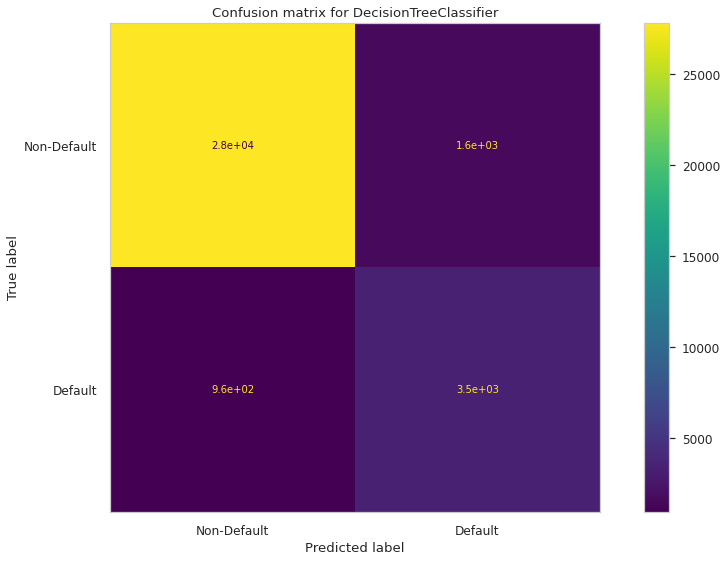

Accuracy: 0.92
Balanced Accuracy: 0.86
MCC: 0.69

Params: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': None, 'splitter': 'best'}


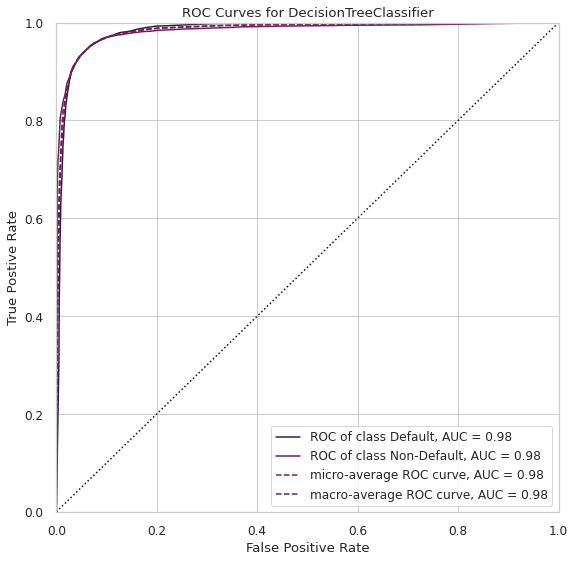

In [390]:
# TODO: perform randomized search first. Use as boilerplate for other models laster V / M
# TODO: When is which distribution suitable?
#distributions = dict(criterion=['gini', 'entropy'], max_depth=uniform(loc=2, scale=4), min_samples_leaf=[0.5, 1], min_weight_fraction_leaf=expon(scale=.1))
#rand_dt = RandomizedSearchCV(DecisionTreeClassifier(), distributions, random_state=42, n_iter=20)
#search = rand_dt.fit(X_train, y_train)
#print(search.best_params_)

# max_depth = [2, 6, 10, 14...]
min_depth = 2
step_size = 4
step_count = 2 ** 4
max_depth = min_depth + np.arange(step_count) * step_size

# perform grid search
param_grid = {'criterion': ['gini', 'entropy'], 'max_depth': max_depth}
grid_dt = GridSearchCV(DecisionTreeClassifier(), param_grid, refit=True, verbose=0)
grid_dt.fit(X_train, y_train)

# choose best model
grid_dt_optimized = grid_dt.best_estimator_

# print confusion 
performance_metrics = print_results(grid_dt_optimized, results)

print_performance_measures(grid_dt_optimized)

In [391]:
performance_metrics

,Accuracy,Balanced Accuracy,Matthews Corrcoef
LogisticRegression,0.906836,0.904517,0.809506
DecisionTreeClassifier,0.923651,0.864452,0.686674


### Plot Decision Tree

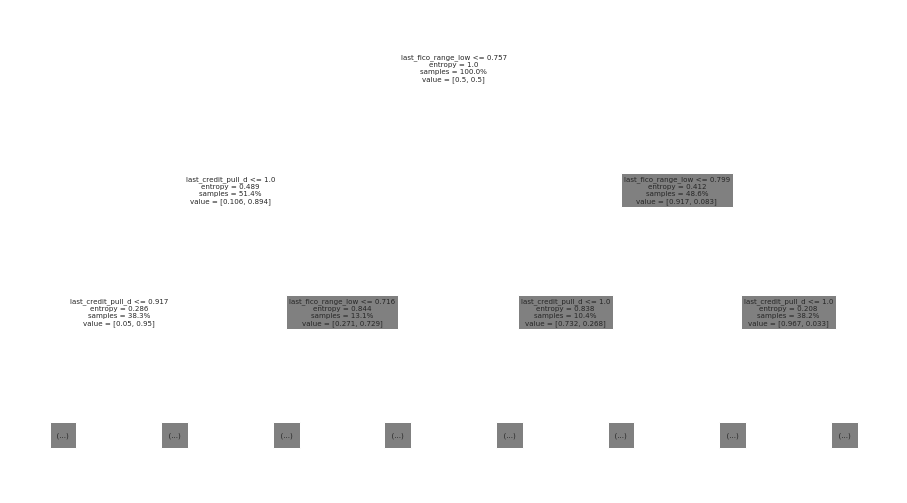

In [392]:
fig, ax = plt.subplots(figsize=(16, 9))
tree.plot_tree(grid_dt_optimized, feature_names=X_train.columns, proportion=True, max_depth=2);

### Plot feature importances of Decision Tree

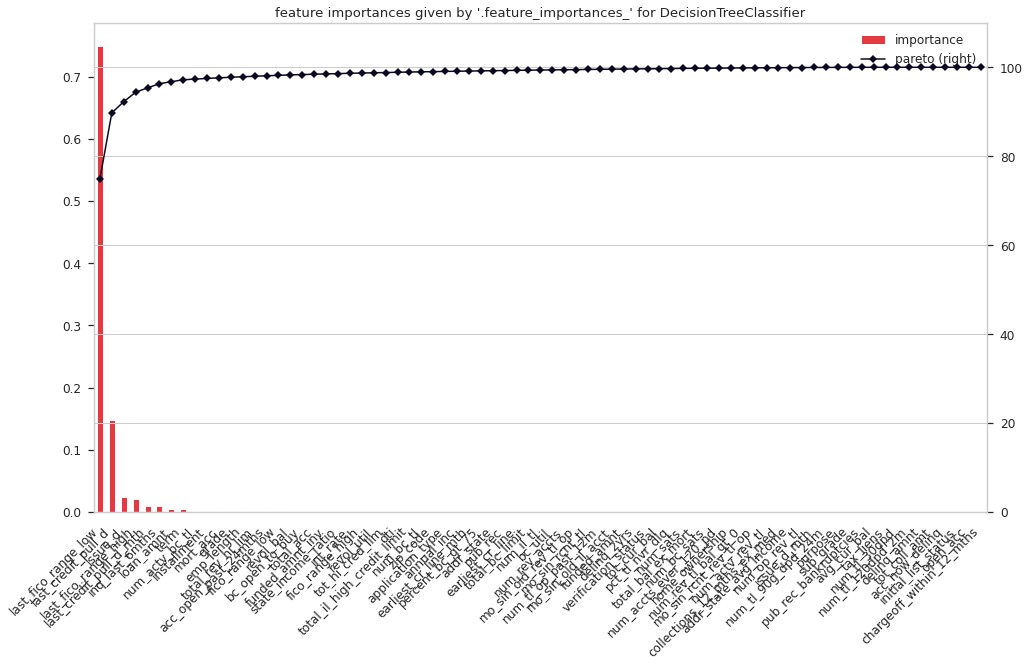

In [393]:
def print_feature_importance(feature_importance):
    """
    function to create a paretto plot with the gini importance of features.
    """
    feature_importance.sort_values(ascending=False, inplace=True, by=0)

    feature_importance['pareto'] = 100 * feature_importance[0].cumsum() / feature_importance[0].sum()
    feature_importance.rename(columns={0: 'importance'}, inplace=True)

    fig, axes = plt.subplots(figsize=(16, 9))
    ax1 = feature_importance.plot(use_index=True, y='importance', kind='bar', ax=axes, color=cmap(150))
    ax2 = feature_importance.plot(use_index=True, y='pareto', marker='D', color=cmap(7), kind='line', ax=axes,
                                  secondary_y=True)
    ax2.set_ylim([0, 110])
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
    plt.xticks(rotation=45)
    plt.title(f"feature importances given by '.feature_importances_' for {grid_dt_optimized.__class__.__name__}")
    plt.show()


 
importance = grid_dt_optimized.feature_importances_
feature_importance = pd.DataFrame(importance, X_train.columns)

print_feature_importance(feature_importance)

### Random Forest

In [ ]:
# [2, 6, 10, 14...]
max_depth = np.arange(2, 22, 4)
# [5, 10, 25, 50, 100, 150]
n_estimators = [5, 10, 25, 50, 100, 150]

# perform grid search
param_grid = {'criterion': ['gini', 'entropy'], 'max_depth': max_depth, 'n_estimators': n_estimators,
              'max_features': ['auto', 'sqrt', 'log2']}
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid, refit=True, verbose=0)
grid_rf.fit(X_train, y_train.values.ravel())

# choose best model
grid_rf_optimized = grid_rf.best_estimator_

# print confusion 
performance_metrics = print_results(grid_rf_optimized, results)

print_performance_measures(grid_rf_optimized)

In [ ]:
performance_metrics

### Bagging

In [ ]:
# TODO: Validate results with larger dataset

# perform grid search
param_grid = {'n_estimators': [5, 10, 25, 50, 100, 150], 'max_samples': [1, 2, 3, 4, 5], 'max_features': [1, 2, 3]}
grid_bag = GridSearchCV(BaggingClassifier(), param_grid, refit=True, verbose=0)
grid_bag.fit(X_train, y_train)

# choose best model
grid_bag_optimized = grid_bag.best_estimator_

# print confusion 
performance_metrics = print_results(grid_bag_optimized, results)
print_performance_measures(grid_bag_optimized)

In [ ]:
performance_metrics

### Support Vector Machine

Next, we look at SVM with two different kernels. Namely, a rfb kernel and linear kernel.

In [ ]:
min_c = 0.1
step_size = 0.1
step_count = 15

C = min_c + np.arange(step_count) * step_size

param_grid = {'C': C, 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf', 'linear']}
grid_svm = GridSearchCV(SVC(), param_grid, refit=True, verbose=0)
grid_svm.fit(X_train, y_train.values.ravel())

# choose best model
grid_svm_optimized = grid_svm.best_estimator_

# print confusion 
performance_metrics = print_results(grid_svm_optimized, results)

print_performance_measures(grid_svm_optimized)

In [ ]:
performance_metrics

### Neural Network 

In [ ]:
param_grid = {'activation': ['logistic', 'relu'], 'learning_rate': ['constant', 'invscaling'],
              'hidden_layer_sizes': [(100, 1), (100, 2)], 'early_stopping': True}
grid_nn = GridSearchCV(MLPClassifier(), param_grid, refit=True, verbose=0)
grid_nn.fit(X_train, y_train.values.ravel())

# choose best model
grid_nn_optimized = grid_nn.best_estimator_

# print confusion 
performance_metrics = print_results(grid_nn_optimized, results)

print_performance_measures(grid_nn_optimized)

In [ ]:
performance_metrics

### Voting Classifier

In [ ]:
# TODO: Optional. Combine the best Classifiers e. g. SVM and RF
model_voting = VotingClassifier(estimators=[('SVM', grid_svm_optimized), ('Random Forest', model_rf_optimized)],
                                   voting='hard')
model_voting.fit(X_train, y_train.values.ravel())

# print confusion matrix
print_result(model_voting, results)

## Stacking Classifier

In [ ]:
# TODO: insert Code
estimators = [('Neural Net', grid_nn_optimized), ('Random Forest', grid_rf_optimized)]
model_stacked = StackingClassifier(estimators=estimators,
                                   final_estimator=LogisticRegression(max_iter=200, penalty='l1', solver='liblinear'))

model_stacked.fit(X_train, y_train.values.ravel())

print_results(model_stacked, results)

print_performance_measures(model_stacked)

Bringing it all together....

##Task 5: Use LASSO for variable selection and explain results. (15 points)

In Task 5 we use a LASSO model for variable selection. First we run a grid search to find a suitable value for the penalty weight $\alpha$. We use the metric Area under the curve (AUC) is the criteria for model selection.

In [ ]:
# TODO: LASSO for classification -> < 0.5 / > 0.5?
# TODO: Disucssion suitable for classfication / automatic feature selection (pros and cons) 
# TODO: Move to end

# use LassoCV to find the optimal alpha
lasso = LassoCV(cv=5, random_state=0, max_iter=5000).fit(X, y)
model = SelectFromModel(lasso, prefit=True)
X_new = model.transform(X)
print('X shape: ', X_new.shape)
print('lasso_coef: ', lasso.coef_)
print('lasso_intercept: ', lasso.intercept_)
print('lasso_alpha: ', lasso.alpha_)
lasso_alpha = lasso.alpha_

Next we look at coefficient of the optimized alpha....

In [ ]:
coef_importance = pd.DataFrame(lasso.coef_, index=X.columns)
coef_importance.rename(columns={0: 'importance'}, inplace=True)
coef_importance = coef_importance.iloc[(-np.abs(coef_importance['importance'].values)).argsort()]

fig, axes = plt.subplots(figsize=(16, 9))
ax1 = coef_importance.plot(use_index=True, y='importance', kind='bar', ax=axes, color=cmap(150), legend=False)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
plt.xticks(rotation=45)
plt.title(f"abs. feature importances given by '.coef' for {model.__class__.__name__}")
plt.show()

And more general for varying alpha....

In [ ]:
alphas_lasso, coefs_lasso, _ = lasso_path(X, y, n_alphas=20, fit_intercept=False)

In [ ]:
neg_log_alphas_lasso = -np.log10(alphas_lasso)

# create df with coefs and their importance
df_test = pd.DataFrame(coefs_lasso[0], index=X.columns)
df_test.columns = neg_log_alphas_lasso

# TODO: logscale y axis

# plot
plt.figure(figsize=(20, 20))
g = sns.lineplot(data=df_test.T)
plt.xlabel('-log(alpha)')
plt.ylabel('coefficients')
plt.title('Lasso paths')
plt.legend(bbox_to_anchor=(1.1, 1))
plt.show(g);

## Task 6: Which model do you suggest to the peer-to-peer company? Why? (10 points)

In addition to accuracy-based measures, classifiers can be compared from following aspects:
*   Speed
*   Interpretability (e.g. logistics regression and decision trees are interpretable, rest not really)
*   Robustness: This refers to the ability of the classifiers to classifying noisy data or data with missing values.
*   Scalability: This is the ability of the classifier to work with large amount of data.

In [ ]:
# TODO: Not yet implemented...
# Discussion Voting Classifier -> include short discussion of weaknesses and strengths of models and weaknesses
# Plot Treefunction DT Path tree.plot_tree(clf) 

# Crieria from slide


# Disucssion why accuarcy is a good criteria (balanced data)

# TODO: consider cost function. Loans that can not repaid are more expensive than loans, that are not handed out.